# **Understanding the Concept**

**Autoencoders** are a type of neural network used to compress and reconstruct data. They have two main parts:
1. **Encoder**: compresses the input into a smaller (lower-dimensional) version.
2. **Decoder**: tries to rebuild the original input from that smaller version.

The goal is to minimize the difference between the input and the output. But if not designed carefully, the model might just copy the input (acting like an identity function), which doesn’t teach it anything useful.



**What is a Masked Autoencoder (MAE)?**

Masked Autoencoders (MAEs) are a type of deep learning model used to learn useful features from data without needing labels. They are especially popular in computer vision and are inspired by methods used in natural language processing. The main idea is simple: **hide (or mask) parts of the input and train the model to guess what’s missing**. This helps the model learn meaningful patterns instead of just memorizing.

**How it works:**

**1. Masking the Input**

Before training, a large portion of the input (like image patches) is randomly hidden or set to a constant value (like zero). This forces the **model to focus on understanding the overall structure** of the data in order to fill in the missing parts.
<br>
<br>

**2. Encoder**

The encoder takes only the visible (unmasked) parts of the input. It turns this partial input into a compressed representation, called the latent space. The encoder doesn't see the full image, it has to work with incomplete information.
<br>
<br>

**3. Latent Space**

This is the bottleneck of the model so it's like a small, dense vector that holds the most important features of the visible input. **The goal is to keep only what’s essential and useful for reconstruction.**
<br>
<br>

**4. Decoder**

The decoder takes the **latent space and tries to rebuild the full input, including the missing/masked parts**. It uses layers like transposed convolutions or upsampling to restore the original size and details.
<br>
<br>

**5. Output Layer**

The final output is the **reconstructed version** of the original input. For images, the output values are usually normalized (between 0 and 1) to match pixel intensity.

**Why masking is important**

Masking adds a challenge that pushes the model to understand the data better. Instead of learning to copy inputs, the model learns the underlying structure, like shapes, textures, or patterns. This improves the model’s ability to generalize and makes it useful for tasks like classification, image completion, and denoising.


# **Data Introduction**

## ***Data Understanding: What is in this dataset?***
The Fashion MNIST dataset isn’t made up of colorful fashion photos or magazine pictures,these are grayscale images (black-and-white) of fashion items, designed to test how well a computer model can recognize and classify everyday clothing.
<br>
<br>

Each image in this dataset is a 28×28 pixel picture (very small!) of a single clothing item. Even though the images are tiny and in black-and-white, they still contain enough detail for machine learning models to learn patterns.
<br>
<br>

This dataset was created as a more challenging replacement for the classic MNIST digit dataset (which has handwritten numbers). It helps researchers and students test their image classification models on something more realistic than just digits.
<br>
<br>

So in a nutshell, this dataset contains:
* Grayscale images of clothing items: each image shows one item such as a shirt, sneaker, bag, or coat.
* Labels for each image: each image comes with a label (from 0 to 9), telling you what kind of clothing it

> ***Big thanks for generoulsy brainful people on earth for making excellent contents to sustain the existent of brainless people like me. So here's some references:***
* [Masked Autoencoders in Deep Learning](https://www.geeksforgeeks.org/masked-autoencoders-in-deep-learning/)

In [33]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models
# from tensorflow import keras
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
# from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
# from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim

import tensorflow as tf
SEED = 42
tf.keras.utils.set_random_seed(SEED)

### before i try to implement the dataset to the VIT approach from kaggle that i got from your notebook but i couldn't debug. so i follow the geeksforgeeks approach

In [ ]:
# # Constants for Fashion MNIST
# IMAGE_SIZE = 28
# PATCH_SIZE = 4
# NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
# MASK_PROPORTION = 0.75

# # Model parameters
# LAYER_NORM_EPS = 1e-6
# ENC_PROJECTION_DIM = 128
# DEC_PROJECTION_DIM = 64
# ENC_NUM_HEADS = 4
# ENC_LAYERS = 6
# DEC_NUM_HEADS = 4
# DEC_LAYERS = 2
# ENC_TRANSFORMER_UNITS = [ENC_PROJECTION_DIM * 2, ENC_PROJECTION_DIM]
# DEC_TRANSFORMER_UNITS = [DEC_PROJECTION_DIM * 2, DEC_PROJECTION_DIM]

In [ ]:
# # Load Fashion MNIST (grayscale, expand to 3 channels)
# (x_train, _), (x_test, _) = fashion_mnist.load_data()
# x_train = np.expand_dims(x_train, -1) / 255.0
# x_test = np.expand_dims(x_test, -1) / 255.0
# x_train = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_train, dtype=tf.float32))
# x_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test, dtype=tf.float32))


In [ ]:
# # Batch and prepare dataset
# BATCH_SIZE = 64
# train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1024).batch(BATCH_SIZE)
# valid_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)


In [ ]:
# # Patch extraction layer
# class Patches(L.Layer):
#     def __init__(self, patch_size=PATCH_SIZE):
#         super().__init__()
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding='VALID',
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

#     def reconstruct_from_patch(self, patch_set):
#         patch_set = tf.reshape(patch_set, (NUM_PATCHES, PATCH_SIZE, PATCH_SIZE, 3))
#         rows = []
#         for i in range(IMAGE_SIZE // PATCH_SIZE):
#             row = tf.concat(
#                 patch_set[i * (IMAGE_SIZE // PATCH_SIZE):(i + 1) * (IMAGE_SIZE // PATCH_SIZE)],
#                 axis=1
#             )
#             rows.append(row)
#         image = tf.concat(rows, axis=0)
#         return image.numpy()

In [ ]:
# # Encoder with masking
# class PatchEncoder(L.Layer):
#     def __init__(self, patch_size=PATCH_SIZE, projection_dim=ENC_PROJECTION_DIM,
#                  mask_proportion=MASK_PROPORTION, downstream=False, **kwargs):
#         super().__init__(**kwargs)
#         self.patch_size = patch_size
#         self.projection_dim = projection_dim
#         self.mask_proportion = mask_proportion
#         self.downstream = downstream
#         self.mask_token = tf.Variable(
#             tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
#         )

#     # def build(self, input_shape):
#     #     (_, self.num_patches, self.patch_area) = input_shape
#     #     self.projection = L.Dense(units=self.projection_dim)
#     #     self.position_embedding = L.Embedding(
#     #         input_dim=self.num_patches, output_dim=self.projection_dim
#     #     )
#     #     self.num_mask = int(self.mask_proportion * self.num_patches)
#     def build(self, input_shape):
#         self.num_patches = input_shape[1]  # infer from (batch, num_patches, dim)
#         self.projection = L.Dense(units=self.projection_dim)
#         self.position_embedding = L.Embedding(
#             input_dim=self.num_patches, output_dim=self.projection_dim
#         )

#         self.encoder = keras.Sequential([
#             layers.LayerNormalization(),
#             layers.Dense(self.projection_dim, activation='gelu'),
#             layers.Dense(self.projection_dim),
#         ])

#         self.decoder = keras.Sequential([
#             layers.LayerNormalization(),
#             layers.Dense(self.projection_dim, activation='gelu'),
#             layers.Dense(self.projection_dim),
#         ])

#         self.encoder_to_decoder = layers.Dense(self.projection_dim)

#         self.num_mask = int(self.mask_proportion * self.num_patches)


#     def call(self, patches):
#         batch_size = tf.shape(patches)[0]
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
#         pos_embeddings = tf.tile(pos_embeddings, [batch_size, 1, 1])
#         patch_embeddings = self.projection(patches) + pos_embeddings

#         if self.downstream:
#             return patch_embeddings

#         mask_indices, unmask_indices = self.get_random_indices(batch_size)
#         unmasked_embeddings = tf.gather(patch_embeddings, unmask_indices, axis=1, batch_dims=1)
#         unmasked_positions = tf.gather(pos_embeddings, unmask_indices, axis=1, batch_dims=1)
#         masked_positions = tf.gather(pos_embeddings, mask_indices, axis=1, batch_dims=1)

#         mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
#         mask_tokens = tf.repeat(mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0)
#         masked_embeddings = self.projection(mask_tokens) + masked_positions

#         return unmasked_embeddings, masked_embeddings, unmasked_positions, mask_indices, unmask_indices

#     def get_random_indices(self, batch_size):
#         rand_indices = tf.argsort(
#             tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
#         )
#         mask_indices = rand_indices[:, : self.num_mask]
#         unmask_indices = rand_indices[:, self.num_mask :]
#         return mask_indices, unmask_indices

#     def generate_masked_image(self, patches, unmask_indices):
#         idx = np.random.choice(patches.shape[0])
#         patch = patches[idx]
#         unmask_index = unmask_indices[idx]
#         new_patch = np.zeros_like(patch)
#         for i in range(unmask_index.shape[0]):
#             new_patch[unmask_index[i]] = patch[unmask_index[i]]
#         return new_patch, idx

# # Dense projection block
# def dense_projection(x, dropout_rate, hidden_units):
#     for units in hidden_units:
#         x = L.Dense(units, activation=tf.nn.gelu)(x)
#         x = L.Dropout(dropout_rate)(x)
#     return x

# # Encoder
# def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
#     inputs = L.Input((None, ENC_PROJECTION_DIM))
#     x = inputs
#     for _ in range(num_layers):
#         x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
#         attention_output = L.MultiHeadAttention(
#             num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
#         )(x1, x1)
#         x2 = L.Add()([attention_output, x])
#         x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
#         x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
#         x = L.Add()([x3, x2])
#     outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
#     return keras.Model(inputs, outputs, name="mae_encoder")

# # Decoder
# def create_decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE):
#     inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
#     x = L.Dense(DEC_PROJECTION_DIM)(inputs)
#     for _ in range(num_layers):
#         x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
#         attention_output = L.MultiHeadAttention(
#             num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
#         )(x1, x1)
#         x2 = L.Add()([attention_output, x])
#         x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
#         x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
#         x = L.Add()([x3, x2])
#     x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
#     x = L.Flatten()(x)
#     pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
#     outputs = L.Reshape((image_size, image_size, 3))(pre_final)
#     return keras.Model(inputs, outputs, name="mae_decoder")


In [ ]:
# # Monitor callback
# test_images = next(iter(valid_ds))
# class TrainMonitor(keras.callbacks.Callback):
#     def __init__(self, epoch_interval=10):
#         self.epoch_interval = epoch_interval

#     def on_epoch_end(self, epoch, logs=None):
#         if epoch % self.epoch_interval == 0:
#             test_patches = self.model.patch_layer(test_images)
#             test_unmasked_embeddings, test_masked_embeddings, test_unmasked_positions, test_mask_indices, test_unmask_indices = self.model.patch_encoder(test_patches)
#             test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
#             test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
#             test_decoder_inputs = tf.concat([test_encoder_outputs, test_masked_embeddings], axis=1)
#             test_decoder_outputs = self.model.decoder(test_decoder_inputs)

#             test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(test_patches, test_unmask_indices)
#             original_image = test_images[idx]
#             masked_image = self.model.patch_layer.reconstruct_from_patch(test_masked_patch)
#             reconstructed_image = test_decoder_outputs[idx]

#             fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#             ax[0].imshow(original_image)
#             ax[0].set_title("Original")
#             ax[1].imshow(masked_image)
#             ax[1].set_title("Masked")
#             ax[2].imshow(reconstructed_image)
#             ax[2].set_title("Reconstructed")
#             plt.show()
#             plt.close()


In [ ]:
# # Build and compile model
# patch_layer = Patches()
# patch_encoder = PatchEncoder()
# encoder = create_encoder()
# decoder = create_decoder()
# mae_model = MaskedAutoencoder(
#     patch_layer=patch_layer,
#     patch_encoder=patch_encoder,
#     encoder=encoder,
#     decoder=decoder
# )


In [ ]:
# mae_model.compile(
#     optimizer="adam",
#     loss=keras.losses.MeanSquaredError(),
#     metrics=["mae"]
# )

In [ ]:
# es = keras.callbacks.EarlyStopping(
#     min_delta=1e-4,
#     patience=5,
#     verbose=1,
#     restore_best_weights=True
# )

# rlp = keras.callbacks.ReduceLROnPlateau(
#     patience=2,
#     verbose=1
# )

In [ ]:
# # Train
# EPOCHS = 50
# history = mae_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=valid_ds,
#     callbacks=[
#         TrainMonitor(epoch_interval=5),  # Custom visualization every 5 epochs
#         es,
#         rlp
#     ]
# )

# loss, mae = mae_model.evaluate(valid_ds)
# print(f"Loss: {loss:.2f}")
# print(f"MAE: {mae:.2f}")

Epoch 1/50


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

# **Prepare Data**

In [19]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (for Conv2D layers)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


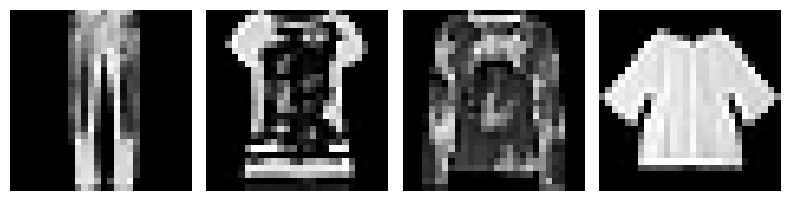

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(8, 3))

for idx in range(4):
    batch_idx = np.random.randint(x_train.shape[0])
    ax[idx].imshow(x_train[batch_idx], cmap='gray')
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

# **Masking Layer**

In [21]:
class MaskingLayer(layers.Layer):
    def __init__(self, mask_ratio=0.5, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
        self.mask_ratio = mask_ratio

    def call(self, inputs):
        # create a random mask
        mask = tf.random.uniform(shape=tf.shape(inputs)) > self.mask_ratio
        return tf.where(mask, inputs, tf.zeros_like(inputs))

masking_layer = MaskingLayer(mask_ratio=0.5)
masked_x_train = masking_layer(x_train[:5])

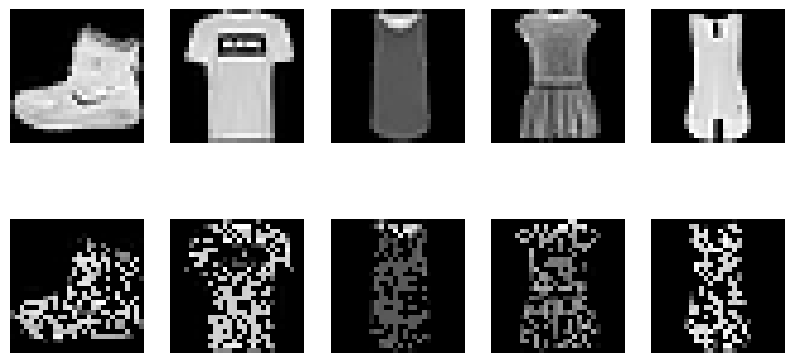

In [22]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(masked_x_train[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

# **Training**

In [23]:
# Encoder
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    latent = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    return models.Model(inputs, latent, name='encoder')

In [24]:
# Decoder
def build_decoder(latent_shape):
    inputs = layers.Input(shape=latent_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(inputs, outputs, name='decoder')

In [25]:
input_shape = x_train.shape[1:]
encoder = build_encoder(input_shape)
latent_shape = encoder.output_shape[1:]
decoder = build_decoder(latent_shape)

In [30]:
# Masked Autoencoder
inputs = layers.Input(shape=input_shape)
masked_inputs = MaskingLayer(mask_ratio=0.5)(inputs)
latent = encoder(masked_inputs)
outputs = decoder(latent)
autoencoder = models.Model(inputs, outputs, name='masked_autoencoder')

**Loss: Binary Crossentropy**
We use binary crossentropy because our images are normalized to the range [0, 1], and the model’s output is a pixel-wise probability. This loss helps the model learn how close each pixel is to being 0 or 1, making it effective for image reconstruction tasks like denoising.
<br>
<br>
**Metrics**
1. **MAE (Mean Absolute Error):** Measures the average difference between predicted and actual pixel values. It's easy to interpret and shows overall reconstruction error.
<br>
<br>
2. **MSE (Mean Squared Error):** Emphasizes larger errors more than MAE, helping the model pay attention to significant pixel differences.
<br>
<br>
3. **Cosine Similarity:** Checks how similar the predicted image is to the actual one in terms of overall shape or structure, rather than individual pixel values. It’s useful to see if the model is capturing the right patterns.

In [31]:
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['mae', 'mse', 'cosine_similarity']
)
autoencoder.summary()

Model: "masked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_layer_5 (MaskingLayer)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 7, 7, 128)      │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       240,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,            # stop if no improvement after 10 epochs
    restore_best_weights=True
)

In [38]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - cosine_similarity: 0.4981 - loss: 0.2604 - mae: 0.0361 - mse: 0.0064 - val_cosine_similarity: 0.5001 - val_loss: 0.2626 - val_mae: 0.0360 - val_mse: 0.0064
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - cosine_similarity: 0.4981 - loss: 0.2601 - mae: 0.0359 - mse: 0.0063 - val_cosine_similarity: 0.5001 - val_loss: 0.2625 - val_mae: 0.0357 - val_mse: 0.0064
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - cosine_similarity: 0.4981 - loss: 0.2600 - mae: 0.0357 - mse: 0.0063 - val_cosine_similarity: 0.5001 - val_loss: 0.2624 - val_mae: 0.0357 - val_mse: 0.0063
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - cosine_similarity: 0.4981 - loss: 0.2599 - mae: 0.0356 - mse: 0.0063 - val_cosine_similarity: 0.5001 - val_loss: 0.2622 - val_mae: 0.0358 - val_mse: 0.0062
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - cosine_similarity: 0.4981 - loss: 0.2597 - mae: 0.0353 - mse: 0.0062 - val_cosine_similarity: 0

# **Evaluation**

NEXT TIME DON'T USE THE COSINE BECAUSE IT WAS IRRELEVANT

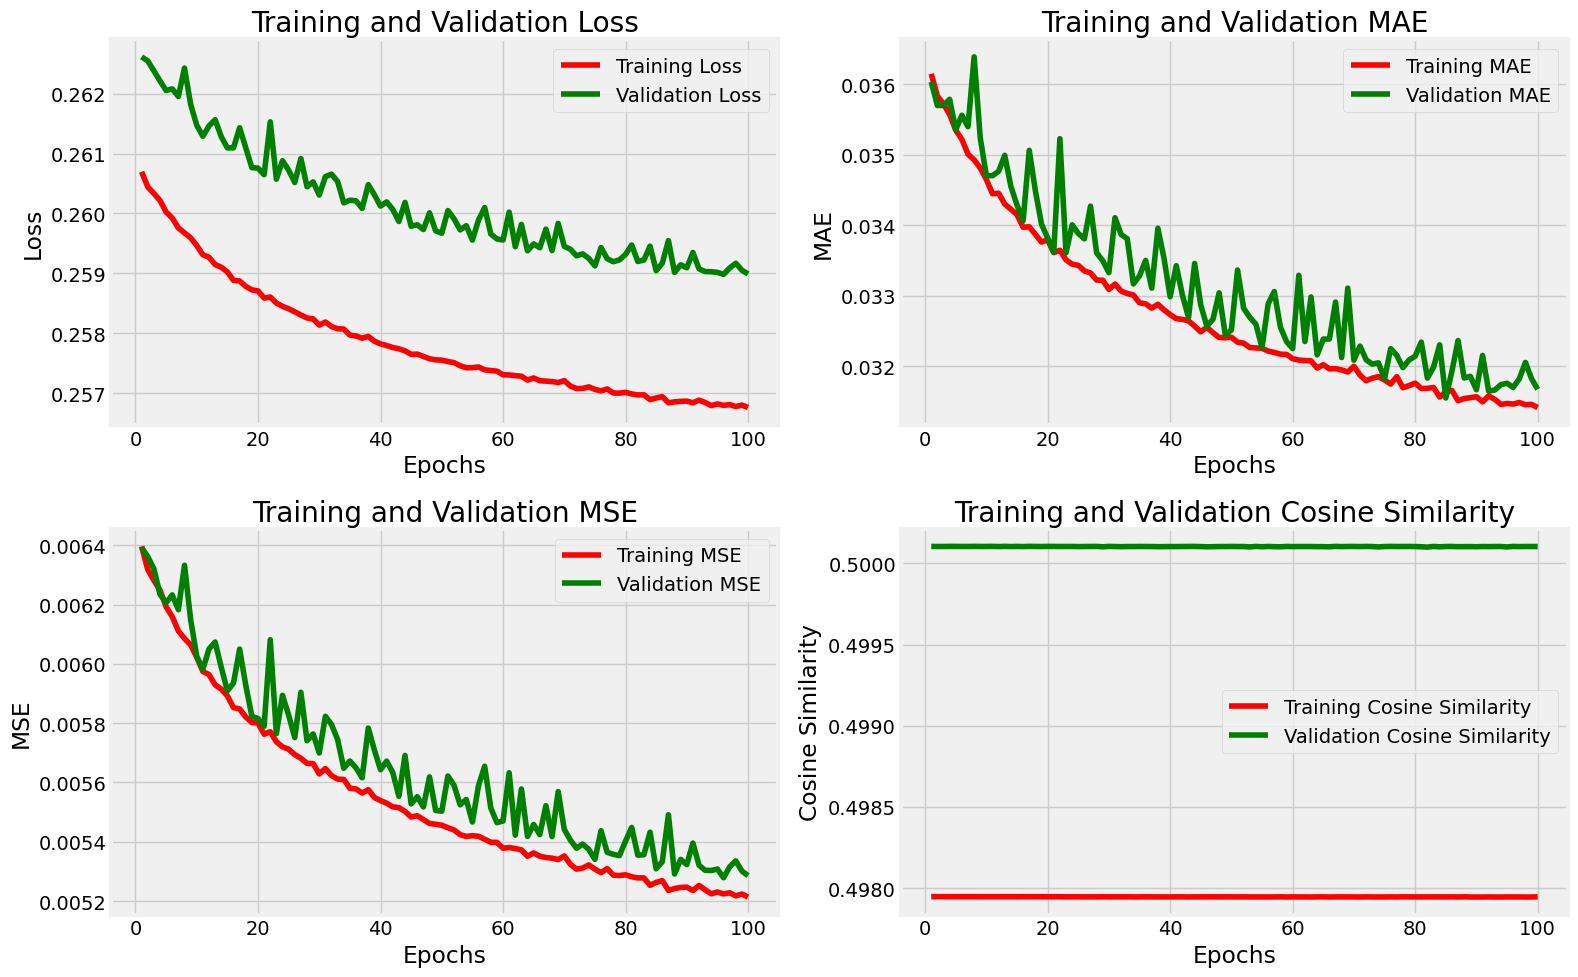

In [39]:
def plot_training_reconstruction(hist):
    tr_loss = hist.history.get('loss')
    val_loss = hist.history.get('val_loss')

    tr_mae = hist.history.get('mae')
    val_mae = hist.history.get('val_mae')

    tr_mse = hist.history.get('mse')
    val_mse = hist.history.get('val_mse')

    tr_cos = hist.history.get('cosine_similarity')
    val_cos = hist.history.get('val_cosine_similarity')

    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(16, 10))
    plt.style.use('fivethirtyeight')

    # loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(2, 2, 2)
    plt.plot(epochs, tr_mae, 'r-', label='Training MAE')
    plt.plot(epochs, val_mae, 'g-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # MSE
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_mse, 'r-', label='Training MSE')
    plt.plot(epochs, val_mse, 'g-', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # cosine similarity
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tr_cos, 'r-', label='Training Cosine Similarity')
    plt.plot(epochs, val_cos, 'g-', label='Validation Cosine Similarity')
    plt.title('Training and Validation Cosine Similarity')
    plt.xlabel('Epochs')
    plt.ylabel('Cosine Similarity')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_reconstruction(history)

**Top Left: Training and Validation Loss**
  * Training loss is gradually decreasing.
  * Validation loss is also decreasing but has more fluctuations.
  * So we can say that the model is learning, and generalization is acceptable. No overfitting is observed.
<br>
<br>

**Top Right: Training and Validation MAE (Mean Absolute Error)**
  * Training MAE decreases steadily.
  * Validation MAE also decreases but is more unstable.
  * It shows that both metrics improve over time. The model performs similarly on both training and validation sets, though validation has more noise.
<br>
<br>

**Bottom Left: Training and Validation MSE (Mean Squared Error)**
  * Training MSE goes down smoothly.
  * Validation MSE follows the same trend but with some variation.
  * Same as MAE, the model is minimizing error well on both datasets although they may have a sign for overfitting, seeing there are some fluctuations of validation line.
<br>
<br>

**Bottom Right: Training and Validation Cosine Similarity**
  * Training cosine similarity stays almost constant (~0.498).
  * Validation cosine similarity is also constant but slightly higher (~0.500).
  * We can say that Cosine similarity isn't improving much, meaning angle-based similarity between outputs and targets is not changing. This metric may not be suitable or relevant for this task.

In [45]:
# Extract metrics from history
mae_values = history.history['val_mae']
mse_values = history.history['val_mse']
cosine_values = history.history['val_cosine_similarity']

# Calculate mean, min, and max for each metric
mean_mae = np.mean(mae_values)
min_mae = np.min(mae_values)
max_mae = np.max(mae_values)

mean_mse = np.mean(mse_values)
min_mse = np.min(mse_values)
max_mse = np.max(mse_values)

mean_cosine = np.mean(cosine_values)
min_cosine = np.min(cosine_values)
max_cosine = np.max(cosine_values)

print("~~~~~~~~~ Evaluation Metrics Summary ~~~~~~~~~ ")
print(f"MAE  - Mean: {mean_mae:.6f} | Min: {min_mae:.6f} | Max: {max_mae:.6f}")
print(f"MSE  - Mean: {mean_mse:.6f} | Min: {min_mse:.6f} | Max: {max_mse:.6f}")
print(f"COS  - Mean: {mean_cosine:.6f} | Min: {min_cosine:.6f} | Max: {max_cosine:.6f}")

~~~~~~~~~ Evaluation Metrics Summary ~~~~~~~~~ 
MAE  - Mean: 0.033145 | Min: 0.031547 | Max: 0.036386
MSE  - Mean: 0.005640 | Min: 0.005279 | Max: 0.006393
COS  - Mean: 0.500103 | Min: 0.500100 | Max: 0.500104


**MAE (Mean Absolute Error)**
* Mean: 0.0331
* Range: 0.0315 (min) to 0.0364 (max)
* On average, the model's predictions are off by about 3.3% in absolute value. The variation is small, showing consistent performance.
<br>
<br>

**MSE (Mean Squared Error)**
* Mean: 0.00564
* Range: 0.00528 to 0.00639
* The squared error is low and stable. A small MSE means large prediction errors are rare.
<br>
<br>

**Cosine Similarity (COS)**
* Mean: 0.500103
* Range: 0.500100 to 0.500104
* Cosine similarity stays nearly constant and close to 0.5, suggesting that the angle between predicted and target vectors isn’t changing much.

CONSIDER DROPPING COSINE SIMILIARITY NEXT TIME


In [49]:
new = autoencoder.predict(x_test)

ssim_scores = []

for denoised, original in zip(new, x_test):
    # Remove the channel dimension (the last dimension) for SSIM
    denoised_img = denoised.squeeze()
    original_img = original.squeeze()

    # Ensure the images are 2D (height, width) for SSIM
    # If squeeze didn't work as expected, check the shape and reshape manually if needed
    if denoised_img.ndim != 2:
        denoised_img = denoised_img.reshape(28, 28)
    if original_img.ndim != 2:
        original_img = original_img.reshape(28, 28)

    score = ssim(
        original_img, # SSIM expects the original image first
        denoised_img, # Then the distorted/denoised image
        data_range=1.0  # since images are normalized to [0, 1]
    )
    ssim_scores.append(score)

ssim_scores = np.array(ssim_scores)
print("Mean SSIM:", np.mean(ssim_scores))
print("Max SSIM:", np.max(ssim_scores))
print("Min SSIM:", np.min(ssim_scores))
print("Index with highest SSIM:", np.argmax(ssim_scores))
print("Index with lowest SSIM:", np.argmin(ssim_scores))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean SSIM: 0.8845445451809179
Max SSIM: 0.9952828177243225
Min SSIM: 0.2702495715173066
Index with highest SSIM: 6606
Index with lowest SSIM: 4203


**SSIM measures image similarity in terms of structure, contrast, and luminance. If 0 (no similarity) and 1 (identical).**
<br>
<br>

**Mean: 0.8845**

→ On average, the reconstructed images are very similar to the originals. This is considered a good score.

**Max SSIM: 0.9953 at index 6606**

→ One image is nearly perfectly reconstructed.

**Min SSIM: 0.2702 at index 4203**

→ One image has poor reconstruction, possibly due to heavy masking or corruption or the model struggle with specific features (like texture, edge detail)
<br>
<br>

**Conclusion:**
Overall quality is high, with most images well reconstructed. A few images (like index 4203) may need further review to understand why the model performed poorly on them.

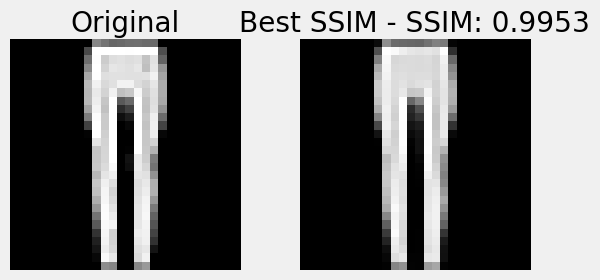

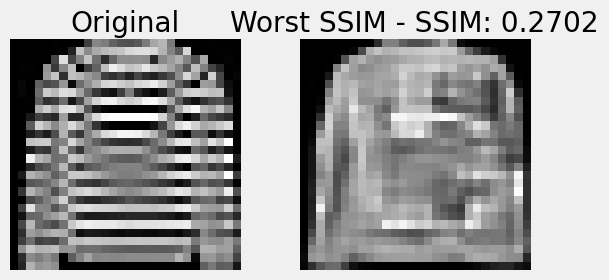

In [51]:
for idx, label in zip([np.argmax(ssim_scores), np.argmin(ssim_scores)], ["Best SSIM", "Worst SSIM"]):
    plt.figure(figsize=(6, 3))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Denoised
    plt.subplot(1, 2, 2)
    plt.imshow(new[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{label} - SSIM: {ssim_scores[idx]:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# **Prediction**

In [47]:
# Encode and decode some images
encoded_imgs = encoder.predict(masked_x_train)
decoded_imgs = decoder.predict(encoded_imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


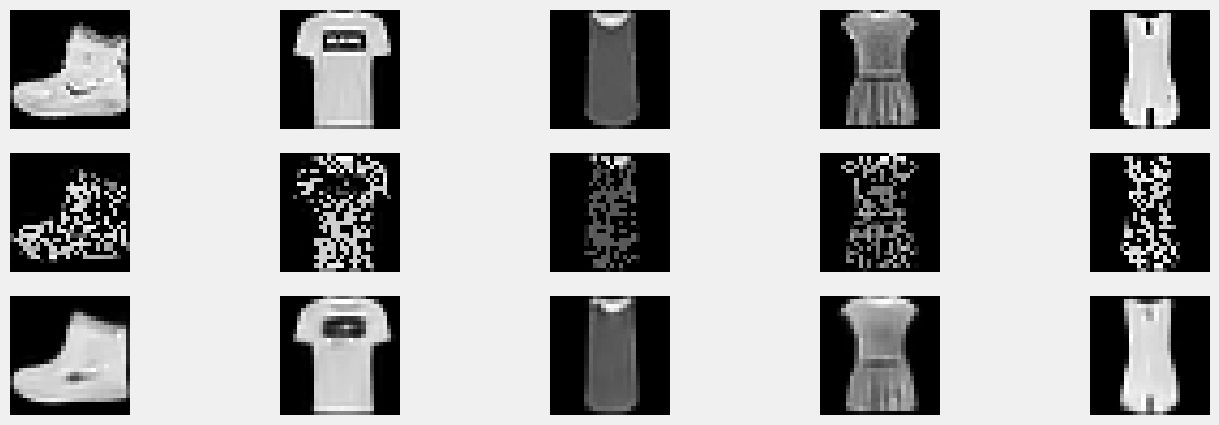

In [48]:
# Plot original, masked, and reconstructed images
plt.figure(figsize=(15, 5))
for i in range(5):
    # Original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')

    # Masked images
    plt.subplot(3, 5, i + 6)
    plt.imshow(masked_x_train[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')

    # Reconstructed images
    plt.subplot(3, 5, i + 11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

# **Conclusion**

A **Masked Autoencoder (MAE) is a deep learning model designed to learn from incomplete data.** In image tasks, it works by dividing an image into patches and randomly masking (hiding) some of them. **The goal of the model is to predict and reconstruct the missing parts based on the visible ones**. This process teaches the model to focus on important structures and patterns in the image, rather than memorizing every detail. The encoder only looks at the visible patches and creates a compact representation, while the decoder uses that information to rebuild the full image.
<br>
<br>

During training, the model tries to minimize the difference between the original and reconstructed images using metrics like loss, MAE (Mean Absolute Error), and MSE (Mean Squared Error). In our case, both training and validation errors were low and stable, showing that the model learned well without overfitting. The SSIM (Structural Similarity Index Measure) was also high for most images, meaning the model did a good job of keeping the structure and quality of the original images. A few images had low SSIM scores, which suggests the model struggled with more complex or unusual inputs.
<br>
<br>

Overall, the Masked AutoEncoder is a powerful and efficient method for learning image representations. Even though it only sees part of the image during training, it can still pedict ther missing parts quite accurately. This makes it useful not only for image reconstruction but also as a foundation for other tasks like classification or segmentation, especially in situations where labeled data is limited.

# **In the Future**

As I mentioned before, I failed to implement the ViT MAE in which we divide the images into patches and feed them into a transformer-based encoder to learn global representations. The method is more complex and requires a deeper understanding of attention mechanisms and positional embeddings.

Maybe next time we should try it with better preparation and more time, so we can explore how transformers handle image reconstruction compared to simpler models like the one I used.

Next project maybe we could try:
* [Masked Autoencoder - Vision Transformer](https://www.kaggle.com/code/ritvik1909/masked-autoencoder-vision-transformer#Augmentation)
* [Masked Image Modeling with Autoencoders](https://www.kaggle.com/code/spsayakpaul/mae-keras#Model-initialization)